https://docs.pymc.io/notebooks/GP-MaunaLoa.html


In [9]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm

## The data

In [10]:
os.makedirs('./data', exist_ok=True)
!wget -O data/mauna-raw.csv http://scrippsco2.ucsd.edu/assets/data/atmospheric/stations/in_situ_co2/monthly/monthly_in_situ_co2_mlo.csv

--2019-11-05 02:34:18--  http://scrippsco2.ucsd.edu/assets/data/atmospheric/stations/in_situ_co2/monthly/monthly_in_situ_co2_mlo.csv
Resolving scrippsco2.ucsd.edu (scrippsco2.ucsd.edu)... 169.228.224.138
Connecting to scrippsco2.ucsd.edu (scrippsco2.ucsd.edu)|169.228.224.138|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 74560 (73K) [text/csv]
Saving to: ‘data/mauna-raw.csv’

data/mauna-raw.csv  100%[===================>]  72.81K   210KB/s    in 0.3s    

2019-11-05 02:34:19 (210 KB/s) - ‘data/mauna-raw.csv’ saved [74560/74560]



In [11]:
raw = pd.read_csv('./data/mauna-raw.csv', header=[54, 55, 56], parse_dates=True)
data = raw.copy()
data.columns = data.columns.map(' '.join).str.strip(' ').str.replace('  ', '')

data = data.rename({'Yr': 'year', 'Mn': 'month'}, axis=1)
data.loc[:, 'day'] = np.ones(data.shape[0])
data.index = pd.to_datetime(data[['year', 'month', 'day']])

mask = data.loc[:, 'CO2 [ppm]'] > -90
data = data.loc[mask, 'CO2 [ppm]'].to_frame()

carbon = data.loc[:, 'CO2 [ppm]'].values
data.loc[:, 'carbon'] = (carbon - carbon[0]) / np.std(carbon)
data.loc[:, 'time'] = (data.index - data.index[0]) / pd.Timedelta(1, 'y')

/Users/adam/.pyenv/versions/3.6.8/envs/teach/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: M and Y units are deprecated and will be removed in a future version.
  


In [12]:
data.head()

,CO2 [ppm],carbon,time
1958-03-01,315.70,0.000000,0.000000
1958-04-01,317.45,0.062329,0.084875
1958-05-01,317.51,0.064466,0.167012
1958-07-01,315.86,0.005699,0.334025
1958-08-01,314.93,-0.027425,0.418900


In [13]:
train = data.loc[:'2005-01-01', :]
test = data.loc['2005-01-01':, :]
assert train.shape[0] > test.shape[0]

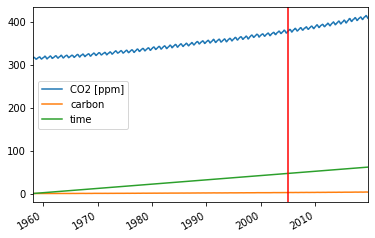

In [14]:
ax = data.plot(kind='line')
ax.axvline(x=test.index[0], c='red')

## Modeling the Keeling Curve using Gaussian Processes

- place somewhat informative priors on the hyperparameters and use optimization to find the MAP point
- we use the gp.Marginal since Gaussian noise is assumed

The R+W model is a sum of three GPs for the signal, and one GP for the noise.

### Slow

A long term smooth rising trend represented by an exponentiated quadratic kernel.

### Medium

A periodic term that decays away from exact periodicity. This is represented by the product of a Periodic covariance function and an exponentiated quadratic.

### Noise

The noise is modeled as the sum of an Exponential and a white noise kernel

### Yearly Periodic

Small and medium term irregularities with a rational quadratic kernel.

## Distributions

### Lengthscale & period

#### Gamma & Normal

The Gamma distribution is an informative prior.  We use gammas for all the length scales, and a normal for the period

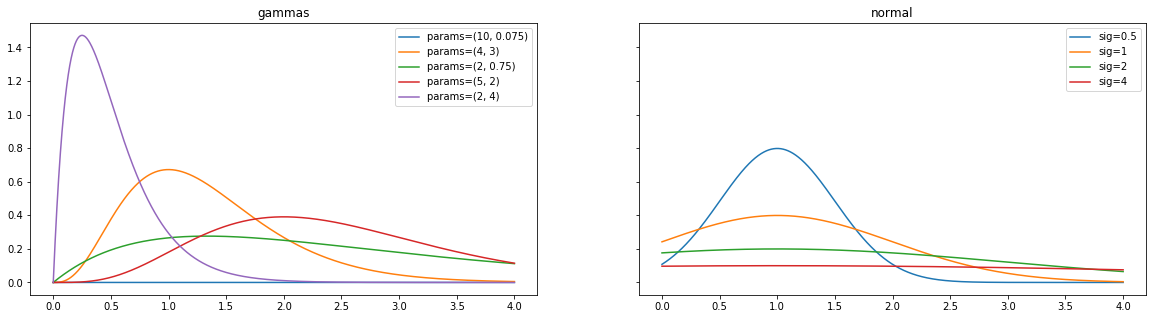

In [15]:
f, axes = plt.subplots(ncols=2, figsize=(20, 5), sharey=True)
x = np.linspace(0, 4, 5000)

params = [
    (10, 0.075), (4, 3), (2, 0.75), (5, 2), (2, 4)
]

a = axes[0]
for p in params:
    gamma = pm.Gamma.dist(*p)
    a.plot(x, np.exp(gamma.logp(x).eval()), label='params={}'.format(p))
    a.set_title('gammas')
    a.legend()
     
sigmas = [0.5, 1, 2, 4]

a = axes[1]
for sig in sigmas:
    norm = pm.Normal.dist(mu=1.0, sigma=sig)
    a.plot(x, np.exp(norm.logp(x).eval()), label='sig={}'.format(sig))
    a.set_title('normal')
    a.legend()

## Distributions

### Scales

#### Half-Cauchy & Half-Normal

We use these distributions for the scales (variances / standard deviations) of
- slow / long term
- short to medium term
- periodic / seasonal
- white noise
- correlated, short term noise

The distributions with the largest effects on the data have the least mass near zero (large value of `beta` or `sigma`)

These distributions are 'fairly' uninformative

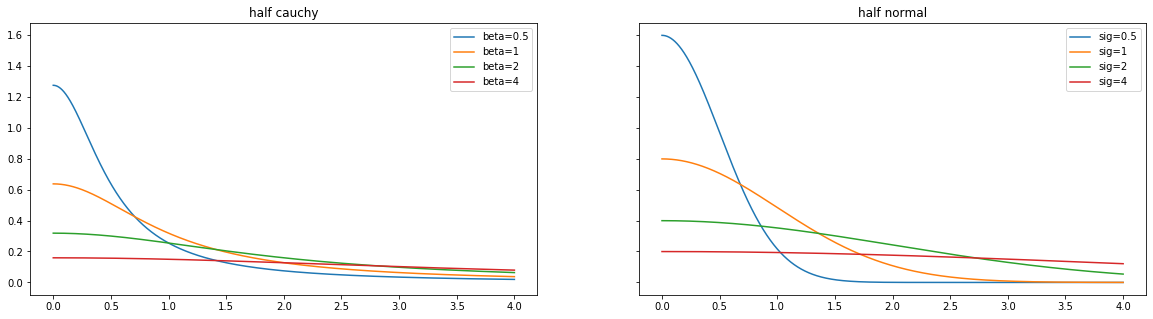

In [16]:
f, axes = plt.subplots(ncols=2, figsize=(20, 5), sharey=True)
x = np.linspace(0, 4, 5000)
betas = [0.5, 1, 2, 4]

a = axes[0]
for beta in betas:
    cauchy = pm.HalfCauchy.dist(beta=beta)
    a.plot(x, np.exp(cauchy.logp(x).eval()), label='beta={}'.format(beta))
    a.set_title('half cauchy')
    a.legend()
     
sigmas = [0.5, 1, 2, 4]

a = axes[1]
for sig in sigmas:
    norm = pm.HalfNormal.dist(sigma=sig)
    a.plot(x, np.exp(norm.logp(x).eval()), label='sig={}'.format(sig))
    a.set_title('half normal')
    a.legend()

## The Model

### Maximum a posteriori estimation

In Bayesian statistics, a maximum a posteriori probability (MAP) estimate is an estimate of an unknown quantity, that equals the mode of the posterior distribution. The MAP can be used to obtain a point estimate of an unobserved quantity on the basis of empirical data. It is closely related to the method of maximum likelihood (ML) estimation, but employs an augmented optimization objective which incorporates a prior distribution (that quantifies the additional information available through prior knowledge of a related event) over the quantity one wants to estimate. MAP estimation can therefore be seen as a regularization of ML estimation.

### Marginal Gaussian Processes

Since we are doing MAP, we use Marginal Gaussian Processes

In [17]:
data.head(3)

,CO2 [ppm],carbon,time
1958-03-01,315.70,0.000000,0.000000
1958-04-01,317.45,0.062329,0.084875
1958-05-01,317.51,0.064466,0.167012


In [18]:
y_train = train.loc[:, 'carbon'].values
x_train = train.loc[:, 'time'].values.reshape(-1, 1)

In [19]:
with pm.Model() as model:
    # yearly periodic component x long term trend
    scale_per = pm.HalfCauchy("scale_per", beta=2, testval=1.0)
    len_pdecay = pm.Gamma("len_pdecay", alpha=10, beta=0.075)
    period  = pm.Normal("period", mu=1, sigma=0.05)
    len_psmooth = pm.Gamma("len_psmooth ", alpha=4, beta=3)
    cov_seasonal = scale_per**2 * pm.gp.cov.Periodic(1, period, len_psmooth) * pm.gp.cov.Matern52(1, len_pdecay)
    gp_seasonal = pm.gp.Marginal(cov_func=cov_seasonal)

    # small/medium term irregularities
    scale_med = pm.HalfCauchy("scale_med", beta=0.5, testval=0.1)
    len_med = pm.Gamma("len_med", alpha=2, beta=0.75)
    alpha = pm.Gamma("α", alpha=5, beta=2)
    cov_medium = scale_med**2 * pm.gp.cov.RatQuad(1, len_med, alpha)
    gp_medium = pm.gp.Marginal(cov_func=cov_medium)

    # long term trend
    scale_trend = pm.HalfCauchy("scale_trend", beta=2, testval=2.0)
    len_trend = pm.Gamma("len_trend", alpha=4, beta=0.1)
    cov_trend = scale_trend**2 * pm.gp.cov.ExpQuad(1, len_trend)
    gp_trend = pm.gp.Marginal(cov_func=cov_trend)

    # noise model
    scale_noise = pm.HalfNormal("scale_noise", sigma=0.5, testval=0.05)
    len_noise = pm.Gamma("len_noise", alpha=2, beta=4)
    noise = pm.HalfNormal("σ",  sigma=0.25, testval=0.05)
    cov_noise = scale_noise**2 * pm.gp.cov.Matern32(1, len_noise) + pm.gp.cov.WhiteNoise(noise)

    # The Gaussian process is a sum of these three components
    gp = gp_seasonal + gp_medium + gp_trend

    # Since the normal noise model and the GP are conjugates, we use `Marginal` with the `.marginal_likelihood` method
    y_ = gp.marginal_likelihood("y", X=x_train, y=y_train, noise=cov_noise)

    # this line calls an optimizer to find the MAP
    mp = pm.find_MAP(include_transformed=True)

/Users/adam/.pyenv/versions/3.6.8/envs/teach/lib/python3.6/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/Users/adam/.pyenv/versions/3.6.8/envs/teach/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
/Users/adam/.pyenv/versions/3.6.8/envs/teach/lib/python3.6/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexi

In [20]:
# display the results, dont show transformed parameter values
sorted([name+":"+str(mp[name]) for name in mp.keys() if not name.endswith("_")])

['len_med:1.6768614152040018',
 'len_noise:6695621974436.086',
 'len_pdecay:20419.999694585716',
 'len_psmooth :601.6327109845151',
 'len_trend:92.10209829064699',
 'period:0.6449505856607433',
 'scale_med:0.00012465647727393655',
 'scale_noise:2.451937569150802e-20',
 'scale_per:0.0020922424254210415',
 'scale_trend:0.6099709961277306',
 'α:1167.7481134262214',
 'σ:3.5450897394078596e-38']

In [21]:
mu, var = gp.predict(x_train, point=mp, diag=True)

mean_pred = mu * np.std(carbon) + carbon[0]
var_pred  = var * np.std(carbon)**2

/Users/adam/.pyenv/versions/3.6.8/envs/teach/lib/python3.6/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/Users/adam/.pyenv/versions/3.6.8/envs/teach/lib/python3.6/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


In [22]:
fit = pd.DataFrame(
    {
        "t": x_train.flatten(), 
        "mu_total": mean_pred, 
        "sd_total": np.sqrt(var_pred),
        "actuals": y_train * np.std(carbon) + carbon[0]
    }, 
    index=train.index
)

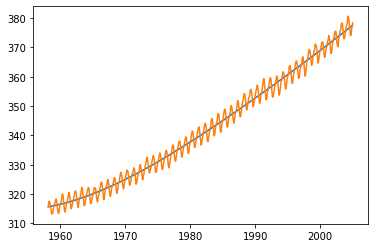

In [25]:
f, ax = plt.subplots()

ax.plot(fit.index.values, fit.loc[:, 'mu_total'].values, label='mu')
ax.plot(fit.index.values, fit.loc[:, 'actuals'].values, label='actuals')